## Description
- Zillow의 주택 가격 평가 모델 :  Zestimate
- '제스티메이트'는 각 매물에 대한 수백 개의 데이터 포인트를 분석하는 750만 개의 통계 및 머신 러닝 모델을 기반으로 한 주택 가치 추정 모델
- kaggle competion(예선) 목적 : **제스티메이트 잔여 오차를 개선**하기 위한 모델을 구축 
    - 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)

- train data :  2016 10 15 이전 거래 데이터 전부와 이후 데이터 일부
- test data : 2016 10 15 ~ 12 31 사이 데이터, 공식 리더보드
- 나머지 test data :  2017.10.15 ~ 12.15. 의 데이터 전부, 비공식 리더보드, 제출 x
- 각 기간 동안 모든 부동산이 판매된 것은 아니므로, 판매되지 않은 부동산은 점수 계산에서 제외됨
- 한 부동산이 31일 내에 여러번 판매된 경우 가장 합리적으로 판매된 가격을 선택

In [91]:
import numpy as np
import pandas as pd #데이터 전처리
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999 #최대 컬럼 표시

In [92]:
from subprocess import check_output
#print(check_output(['ls'])).decode('utf8')

In [93]:
# data 불러오기
train_df = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'])
train_df.shape

(90275, 3)

In [94]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


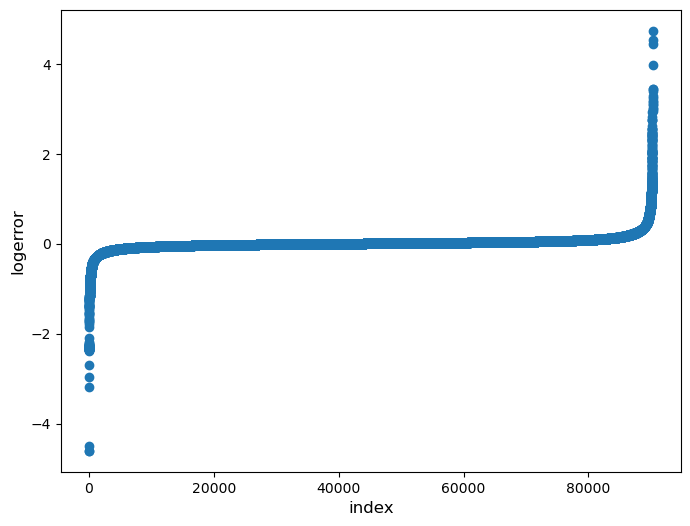

In [95]:
# target이 logerror이므로, logerror 시각화로 확인
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

/var/folders/cx/dsw_f6590_dbbf9c4vf4fyy40000gn/T/ipykernel_2196/2118814626.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.logerror.values, bins=50, kde=False)


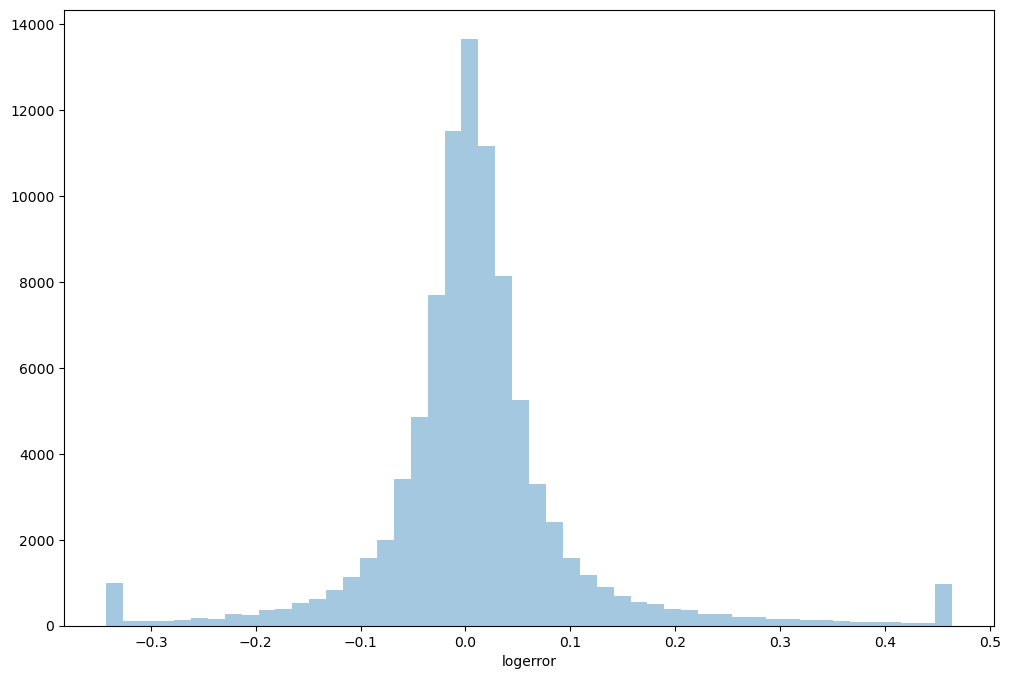

In [96]:
# outlier 제거 후 히스토그램 시각화
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)

# ix 메서드 데신 loc 메서드 사용
train_df['logerror'].loc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].loc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror')
plt.show()

- 아웃라이어를 제외한 값을 봤을때 logerror들이 정규분포의 형태를 띄는 것처럼 보임

### Transaction Date
- transaction date 확인

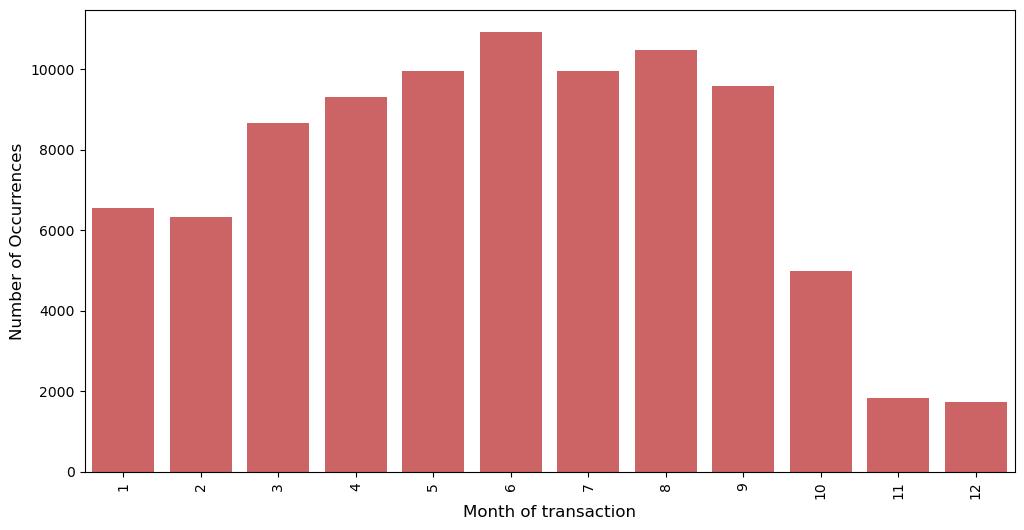

In [97]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

# 거래월의 개수 시리즈 객체에 저장
cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha = 0.8, color=color[3])

plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences',  fontsize=12)
plt.show()

- 3~9월에 거래가 많음
- 데이터에 2016년 10월 15일 이전데이터는 전부, 이후는 일부만 있으므로 11,12월은 데이터가 적음

### Parcel Id

In [98]:
# 거래 횟수별 데이터가 얼마나 있는지?
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [99]:
train_df['parcelid'].value_counts().reset_index()

,index,parcelid
0,11842707,3
1,11633771,2
2,11742566,2
3,14322378,2
4,12097956,2
...,...,...
90145,10841120,1
90146,11232572,1
90147,10988879,1
90148,13056901,1


### Properties 2016 
- Properties 2016 data 확인

In [100]:
prop_df = pd.read_csv('properties_2016.csv')
prop_df.shape

/var/folders/cx/dsw_f6590_dbbf9c4vf4fyy40000gn/T/ipykernel_2196/2073588420.py:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_df = pd.read_csv('properties_2016.csv')


(2985217, 58)

In [101]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


- nan값ㅣ 많으므로 얼나 있는지 확인

In [102]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df
# 각 컬럼별 nan이 얼마나 있는지

,index,0
0,parcelid,0
1,airconditioningtypeid,2173698
2,architecturalstyletypeid,2979156
3,basementsqft,2983589
4,bathroomcnt,11462
5,bedroomcnt,11450
6,buildingclasstypeid,2972588
7,buildingqualitytypeid,1046729
8,calculatedbathnbr,128912
9,decktypeid,2968121


In [103]:
#df의 컬럼명을 컬럼 네임, missing count로 변경
missing_df.columns = ['column_name', 'missing_count']
#missing count가 0보다 큰 값 인덱싱
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')


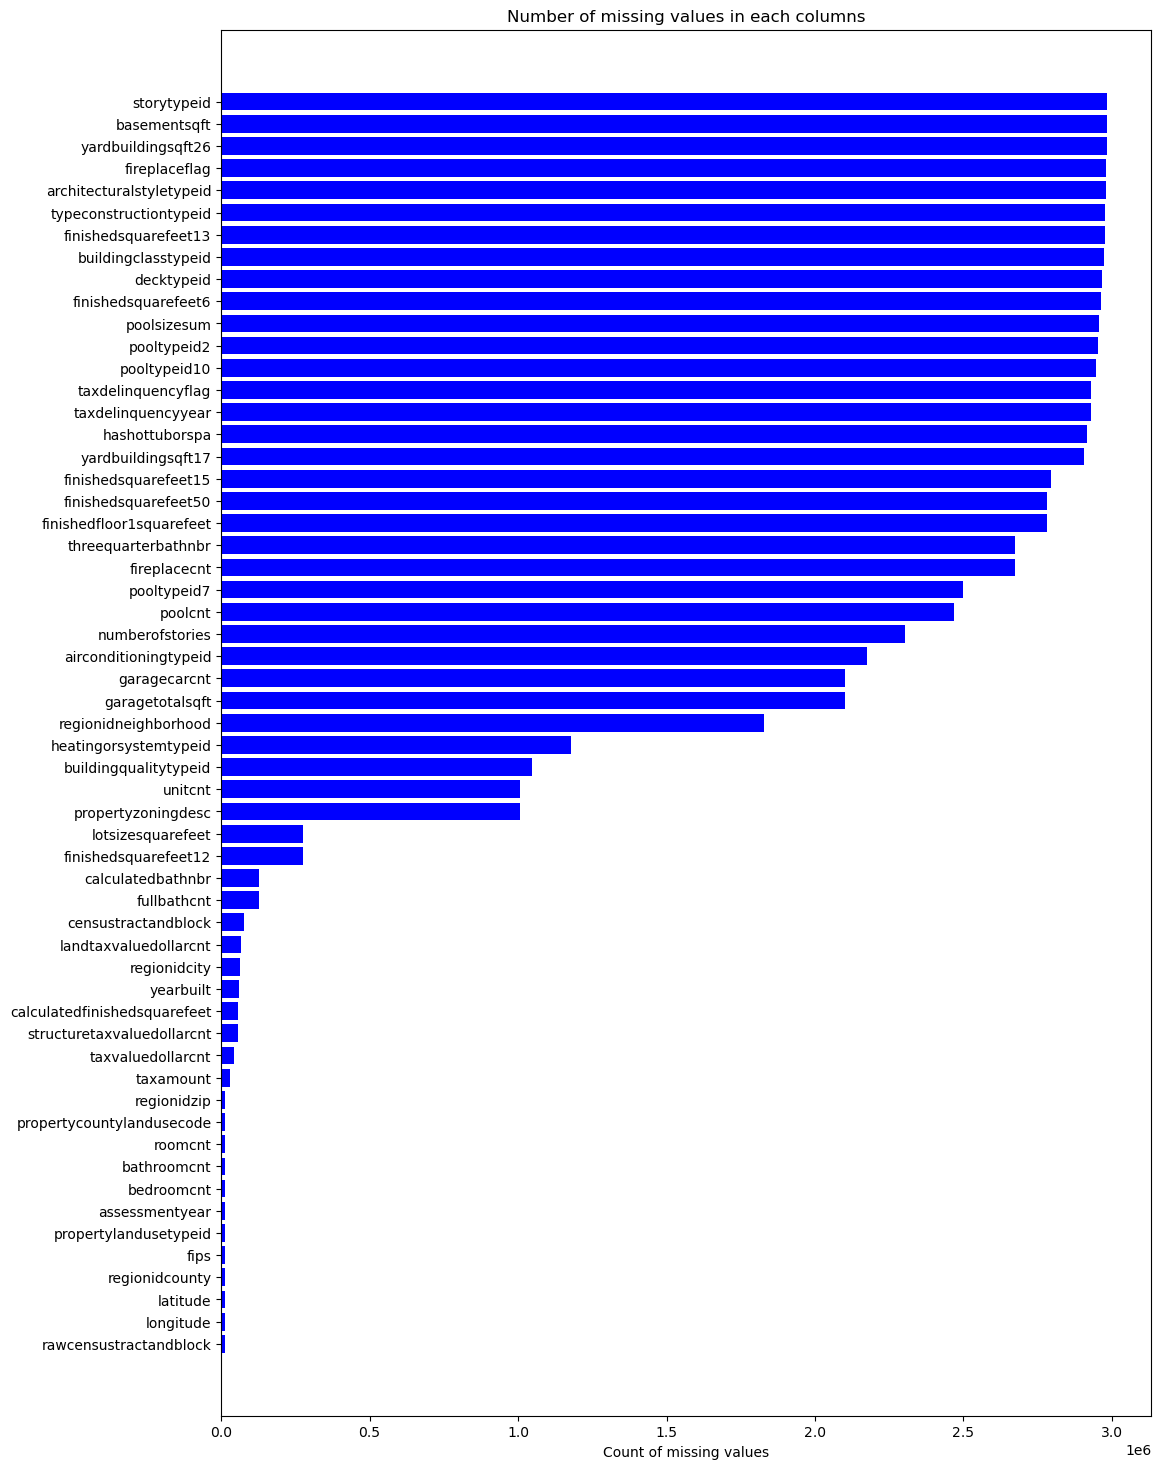

In [104]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel('Count of missing values')
ax.set_title('Number of missing values in each columns')
plt.show()

- 위도, 경도 변수 시각화

<Figure size 1200x1200 with 0 Axes>

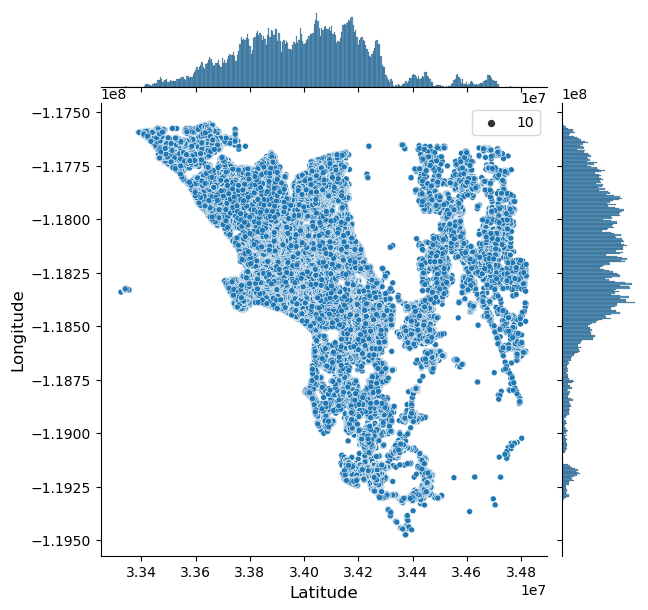

In [105]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

- data에는 로스엔젤레스, 오랑쥬, 밴츄라, 캘리포니아 지역의 부동산 리스트가 있음 
- train data는 90811data 만 있지만, prop_df에는 약 20만개가 있음 => 두 데이터 합병

In [106]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [107]:
# 각 컬럼의 데이터 타입 확인
pd.options.display.max_rows = 65


dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


In [108]:
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


- 대부분 데이터 타입이 float type 임
- merge한 data의 null 값 확인

In [109]:
# 각 컬럼별 null값의 개수가 있는 missing df 생성
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
# missing 비율 컬럼 생성
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
# missing 비율이 0.999를 초과하는 컬럼 확인
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


- 4개의 컬럼이 missing ratio 의 비율이 99.9%가 넘음

### Univariate Analysis
- 변수가 너무 많으므로 float 변수간 관계가 있는지 확인

In [128]:
# missing 값에는 mean 값으로 대체
mean_values = train_df.mean(axis=0, numeric_only=True)
train_df_new = train_df.fillna(pd.DataFrame(mean_values))
train_df.fillna(pd.DataFrame(mean_values), inplace=True)

train_df_new

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.000000,7.229885,713.581395,2.0,3.0,4.0,4.000000,2.0,66.0,1347.974037,1684.0,1684.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,2.0,1.812005,345.521228,NaN,2.000000,34280990.0,-118488536.0,7528.0,1.0,519.827657,1.0,1.0,1.0,0100,261.0,LARS,6.037107e+07,12447.000000,3101.0,31817.000000,96370.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1959.0,1.440739,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,13.402692,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,1.816372,7.229885,713.581395,3.5,4.0,4.0,5.565407,3.5,66.0,1347.974037,2263.0,2263.000000,1404.545455,2380.090067,1355.546674,2302.546318,6059.0,1.187884,3.0,2.000000,468.000000,NaN,3.926979,33668120.0,-117677556.0,3643.0,1.0,519.827657,1.0,1.0,1.0,1,261.0,NaN,6.059052e+07,32380.000000,1286.0,190646.540237,96962.0,0.0,7.0,1.000000,6.010033,1.110414,310.142101,311.694737,2014.0,1.440739,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,13.402692,6.049151e+13
2,12098116,-0.0040,2016-01-01,1,1.000000,7.229885,713.581395,3.0,2.0,4.0,4.000000,3.0,66.0,1347.974037,2217.0,2217.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,3.0,1.812005,345.521228,NaN,2.000000,34136312.0,-118175032.0,11423.0,1.0,519.827657,1.0,1.0,1.0,0100,261.0,PSR6,6.037464e+07,47019.000000,3101.0,275411.000000,96293.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1940.0,1.440739,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,13.402692,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.000000,7.229885,713.581395,2.0,2.0,4.0,4.000000,2.0,66.0,1347.974037,839.0,839.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,2.0,1.812005,345.521228,NaN,2.000000,33755800.0,-118309000.0,70859.0,1.0,519.827657,1.0,1.0,1.0,010C,266.0,LAR3,6.037296e+07,12447.000000,3101.0,54300.000000,96222.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1987.0,1.440739,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,13.402692,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,1.816372,7.229885,713.581395,2.5,4.0,4.0,5.565407,2.5,66.0,1347.974037,2283.0,2283.000000,1404.545455,2380.090067,1355.546674,2302.546318,6059.0,1.187884,2.0,2.000000,598.000000,NaN,3.926979,33485643.0,-117700234.0,6000.0,1.0,519.827657,1.0,1.0,1.0,122,261.0,NaN,6.059042e+07,17686.000000,1286.0,190646.540237,96961.0,8.0,7.0,1.000000,6.010033,1.110414,310.142101,311.694737,1981.0,2.000000,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,13.402692,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,12,1.000000,7.229885,713.581395,1.0,1.0,4.0,4.000000,1.0,66.0,1347.974037,653.0,653.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,1.0,1.812005,345.521228,NaN,2.000000,34203000.0,-118562000.0,93676.0,1.0,519.82

In [142]:
train_df.fillna(pd.DataFrame(mean_values))['bedroomcnt'].value_counts()

3.0     35447
2.0     22357
4.0     20279
5.0      5077
1.0      3897
0.0      1421
6.0      1120
8.0       274
7.0       234
9.0        91
10.0       35
12.0       22
11.0       12
16.0        4
14.0        3
13.0        1
15.0        1
Name: bedroomcnt, dtype: int64

In [130]:
# 변수간 corr check
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []

for col in x_cols:
    labels.append(col) 
    # 컬럼 값과 logerrorr간의 coef를 values list에 append
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
    
    corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
    corr_df = corr_df.sort_values(by='corr_values')
    
    

/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jeongjiyeong/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [131]:
corr_df

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
33,regionidcounty,-0.009844
6,buildingqualitytypeid,-0.006648
41,yardbuildingsqft17,-0.006643
40,unitcnt,-0.005685
48,landtaxvaluedollarcnt,-0.004153
34,regionidneighborhood,-0.003379
30,propertylandusetypeid,-0.002520
35,regionidzip,-0.002490


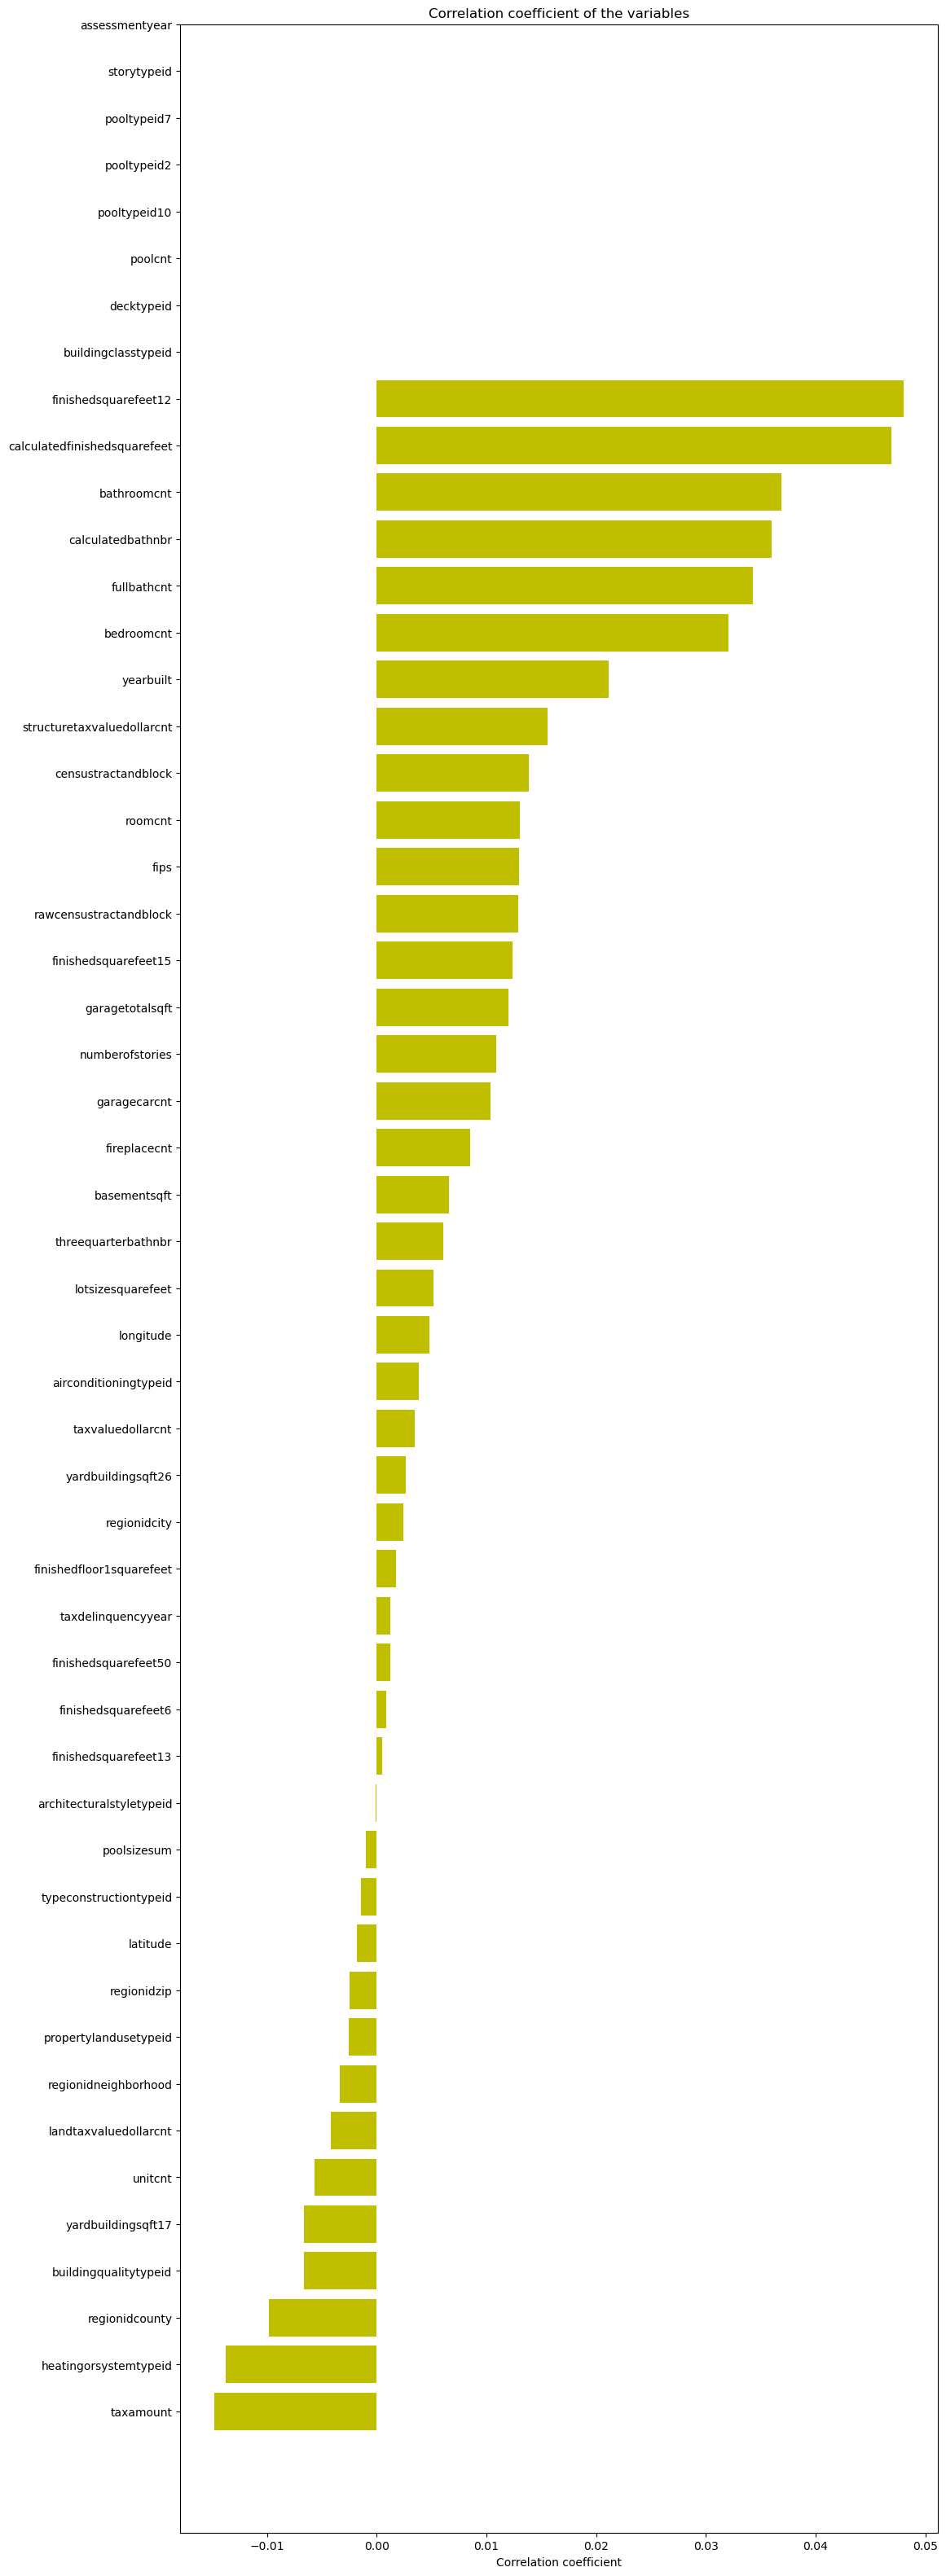

In [132]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')
plt.show()

- target과 변수의 corr는 크지 않음
- 변수 몇개는 corr이 아예 없음 -> unique 값을 가지고 있어서 그런게 아닐까? => 확인

In [133]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']

for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


- corr이 큰 변수들 분석 0.02 초과 혹은 -0.01 미만

In [134]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values']<-0.01)]

corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.046927
11,finishedsquarefeet12,0.048022


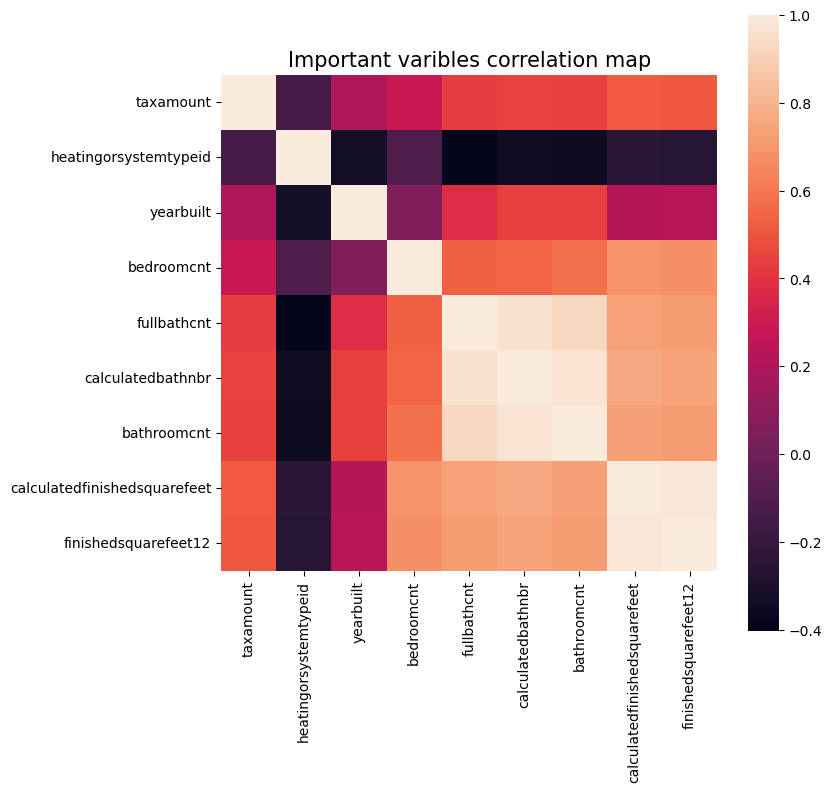

In [135]:
# corr 이 높은 라벨 리스트로 변경
cols_to_use = corr_df_sel.col_labels.tolist()

# 임시 데이터 프레임으로 변경
temp_df = train_df[cols_to_use]

# 라벨간 상관관계 매트릭스 생성
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=1, square=True)
plt.title('Important varibles correlation map', fontsize=15)
plt.show()

- 중요 변수들끼리 상관관계가 높음 => 변수 하나하나 확인

- Finished SquareFeet 12

<Figure size 1200x1200 with 0 Axes>

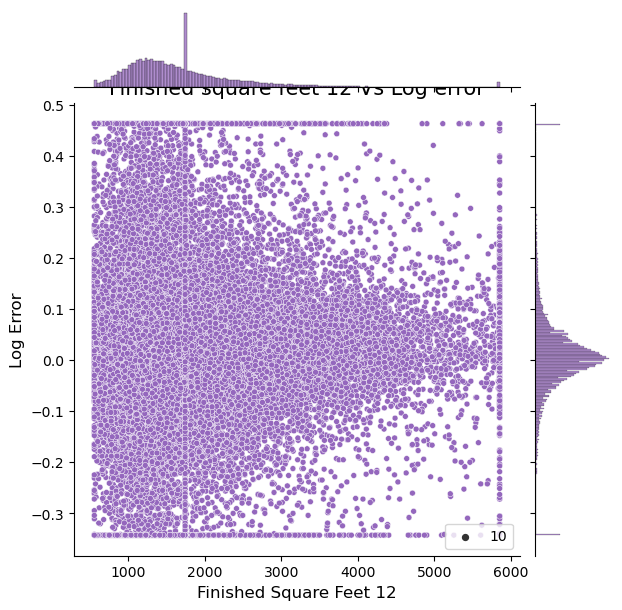

In [136]:
col = 'finishedsquarefeet12'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])

plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title('Finished square feet 12 Vs Log error', fontsize=15)
plt.show()


- finished Square Feet12가 커질 수록 log error 가 줄어듦
- 큰 집일 수 록 예측하기 쉬워 오차가 감소하는 건지?

- Calculated finshed square feet

In [ ]:
col = 'calculatedfinishedsquarefeet'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[4])

plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title('Calculated finished square feet Vs Log error', fontsize=15)
plt.show()


- 이전 분포와 비슷, calculated finished square feet가 증가할 수록 로그에러가 감소하는 경항
- so 두 변수간의 corr이 높은 듯

- Bathroom Count

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='bathroomcnt', data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequecy of Bathroom count', fontsize=15)
plt.show()

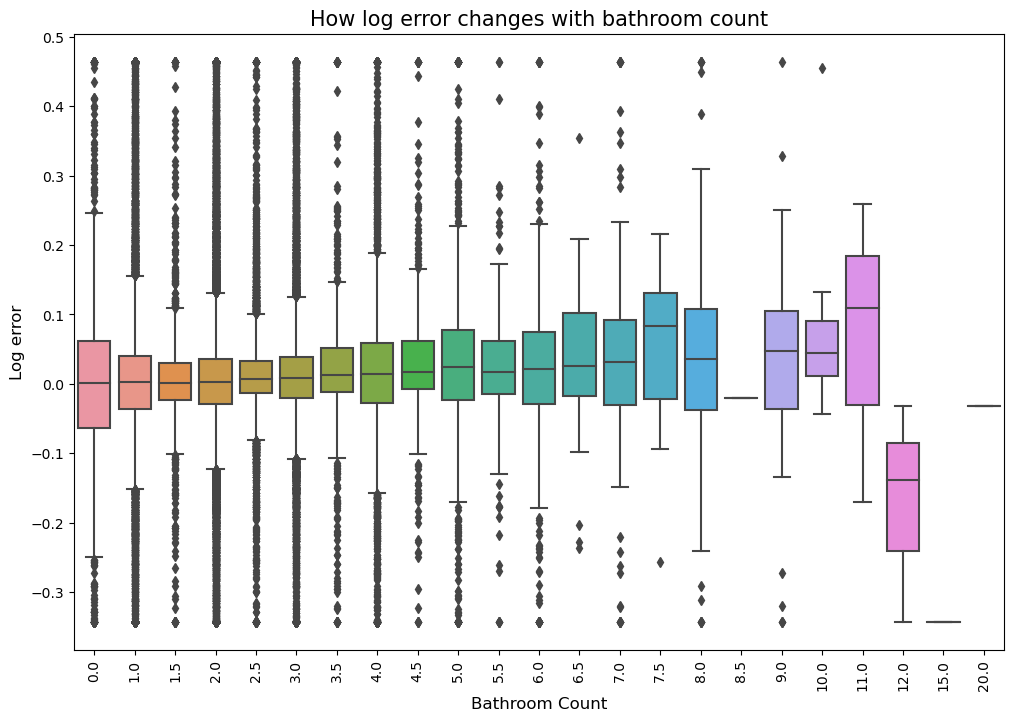

In [137]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='bathroomcnt', y='logerror', data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('How log error changes with bathroom count' ,fontsize=15)
plt.show()

- Bedroom count

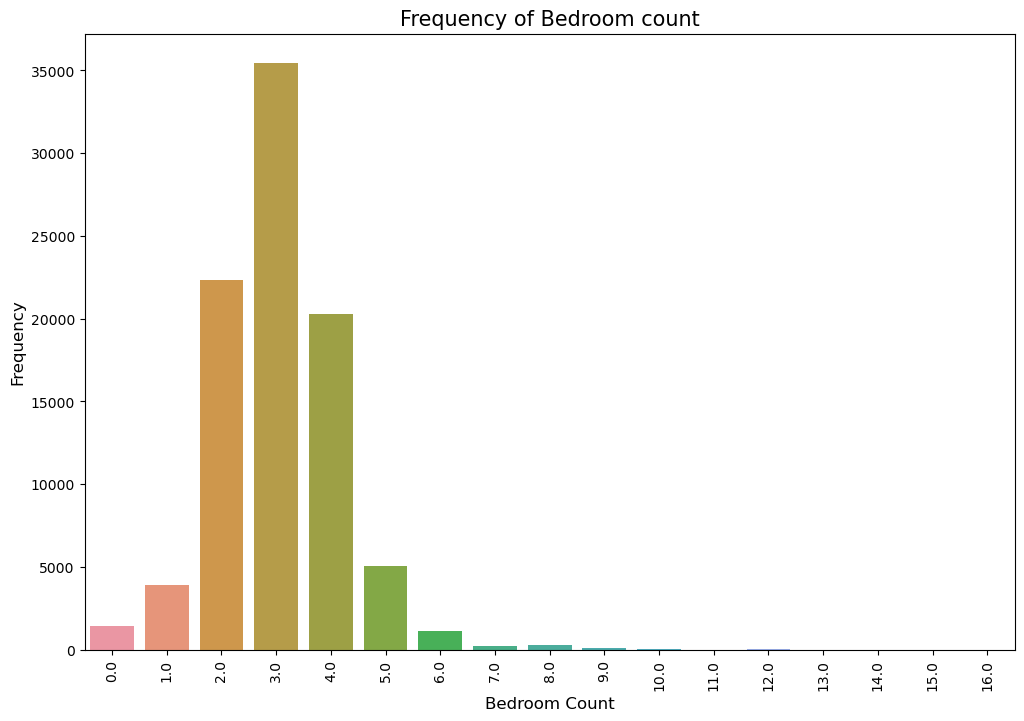

In [138]:
plt.figure(figsize=(12,8))
sns.countplot(x='bedroomcnt', data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation = 'vertical')
plt.title('Frequency of Bedroom count', fontsize=15)
plt.show()

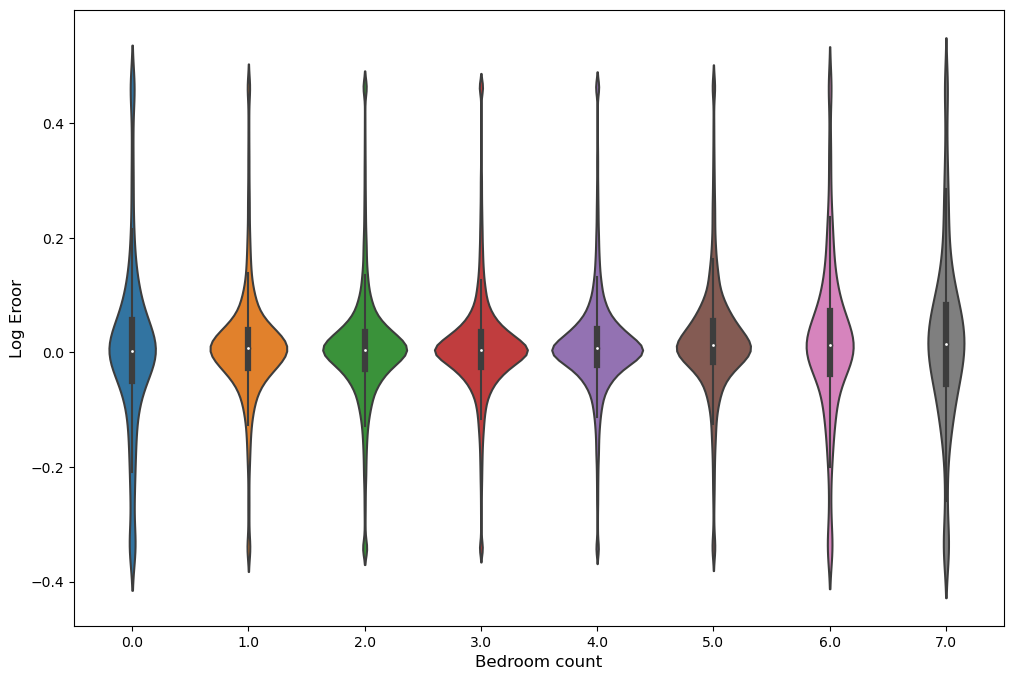

In [143]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12, 8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Eroor', fontsize=12)
plt.show()

<Figure size 1200x1200 with 0 Axes>

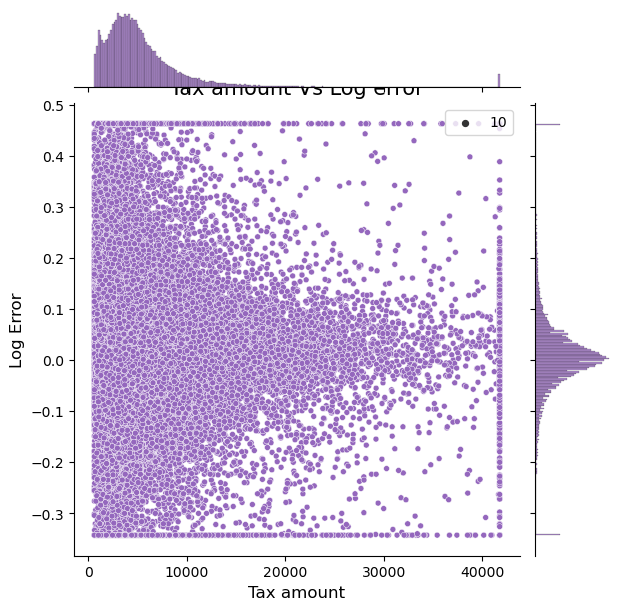

In [144]:
col = 'taxamount'
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.taxamount.values, y=train_df.logerror.values, size=10, color=color[4])

plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax amount', fontsize=12)
plt.title('Tax amount Vs Log error', fontsize=15)
plt.show()

- YearBuilt

In [147]:
pip install ggplot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [155]:
pip install plotnine


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<Figure size 2000x3000 with 0 Axes>

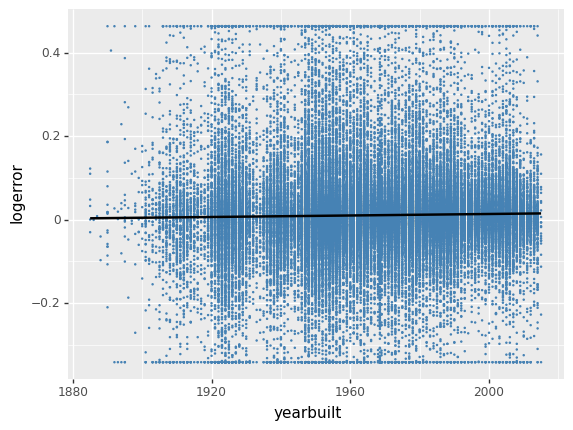

<ggplot: (8760460399364)>

In [170]:
from plotnine import *

fig = plt.figure(figsize=(20,30))
ggplot(train_df, aes(x='yearbuilt', y='logerror')) + geom_point(color = 'steelblue', size=0.001) + stat_smooth()
       
       
       

- 준공연도가 높아질 수록 로그에러가 줄어드는 경향

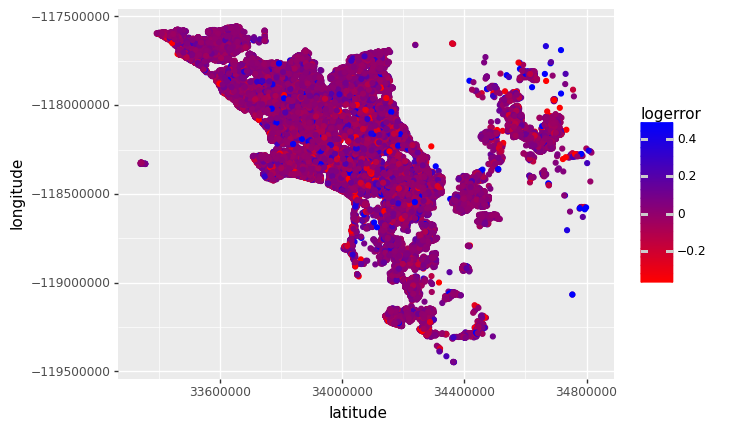

<ggplot: (8760372973629)>

In [174]:
# 지역에 따른 로그에러 확인 => 지역에 따른 경향은 딱히 없어보임
ggplot(train_df, aes(x='latitude', y='longitude', color='logerror')) + geom_point() + scale_color_gradient(low = 'red', high = 'blue')

- 변수 간 상관관계에 따라 패턴이 있는지 확인

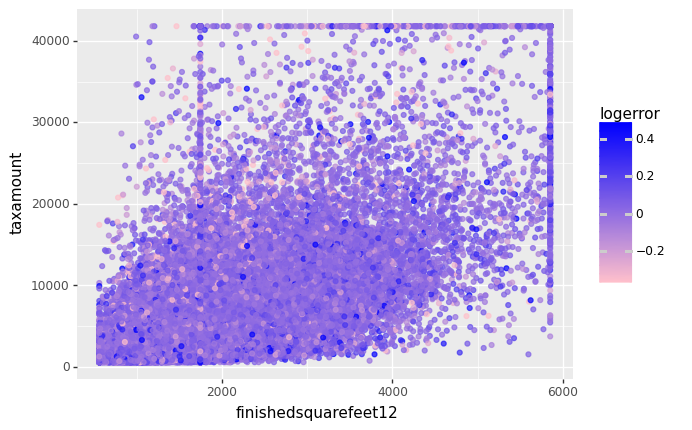

<ggplot: (8760408019601)>

In [175]:
ggplot(train_df, aes(x='finishedsquarefeet12', y='taxamount', color='logerror')) + geom_point(alpha=0.7) + scale_color_gradient(low = 'pink', high='blue')

In [178]:
# 재미로 패턴 만들기
ggplot(train_df, aes(x='finishedsquarefeet12', y='taxamount', color='logerror')) + geom_now_its_art()

NameError: name 'geom_now_its_art' is not defined

- 트리모델 구축

In [179]:
# 타겟 데이터 
train_y = train_df['logerror'].values
# caterical varibles columns list 생성
cat_cols = ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']

# train_df에서 키값, 타겟값, 거래시기와 관련된 컬럼, 카테고리컬 변수들 드랍
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)

feat_names = train_df.columns.values
feat_names

array(['airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13',
       'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt',
       'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt',
  

In [180]:
from sklearn import ensemble

In [182]:
model = ensemble.ExtraTreesRegressor(n_estimators = 25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

ExtraTreesRegressor(max_depth=30, max_features=0.3, n_estimators=25, n_jobs=-1,
                    random_state=0)

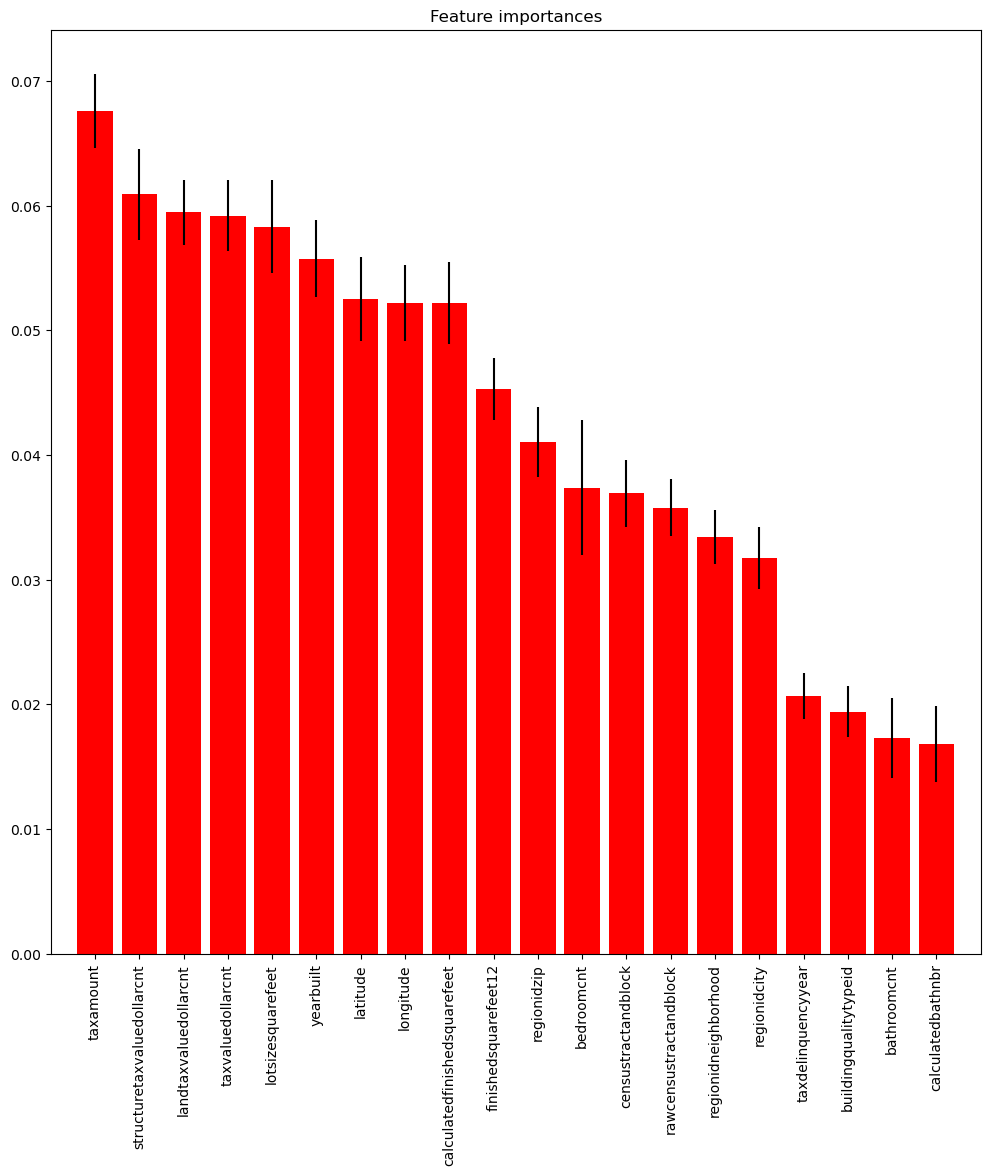

In [187]:
# Feature importance 시각화
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title('Feature importances')
plt.bar(range(len(indices)), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

- 세금 관련 변수들이 가장 중요한 변수인듯; taxamount 부터 등등

In [195]:
import xgboost as xgb
xgb_params = {
    'eta' : 0.05, 
    'max_depth' : 8,
    'subsample' : 0.7,
    'colsample_bytree' : 0.7, 
    'objective' : 'reg:squarederror',
    'verbosity' :1,
    'seed' : 0
}


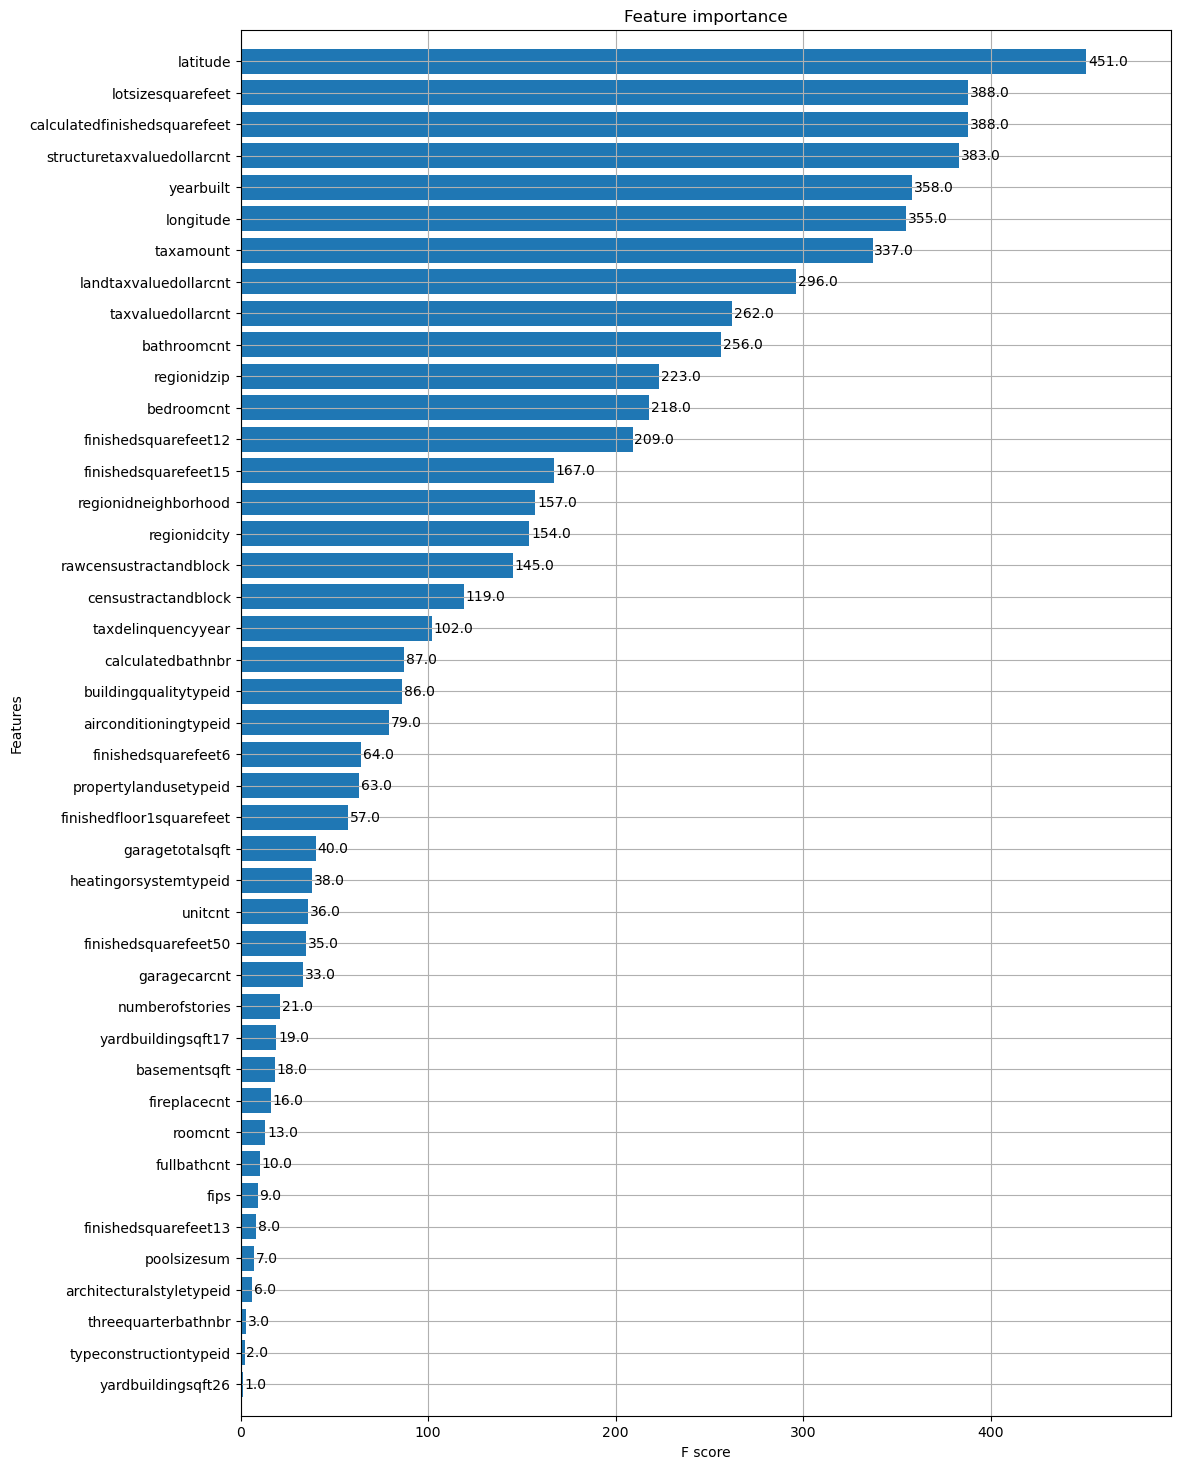

In [197]:
dtrain = xgb.DMatrix(train_df, train_y, feature_names = train_df.columns.values)
model = xgb.train(dict(xgb_params, verbosity=0), dtrain, num_boost_round=50)

fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features=50, height = 0.8, ax=ax)
plt.show()